# **1D Optimal Transport**

The Optimal Transport Cost for 1D distributions can be obtained by:
$$
\int_0^1 h(F_\nu^{-1}(y) - F_\mu^{-1}(y)) dy
$$
Note that for the p-Wasserstein, we obtain:

$$
\left(\int_0^1 |F_\nu^{-1}(y) - F_\mu^{-1}(y)|^p dy\right)^{1/p}
$$

Where $F_\mu^{-1}$ is the quantile function for the distribution $\alpha$ (the inverse of the Cumulative Distribution Function).

Another interesting particular case occurs for $h(z) = |z|$. For such cost function, the formula coincides with:

$$
\int_\mathbb R |F_\mu(x) - F_\nu(x)| dx
$$

In [45]:
using Pkg, Revise
Pkg.activate("../.")

In [46]:
using OptimalTransport, VegaLite, Distributions, LinearAlgebra
using Tulip
using Distances
# using QuadGK, Distances, Tulip
using BenchmarkTools

optimizer = Tulip.Optimizer()

Tulip.Optimizer{Float64}

#### Auxiliary - Plot Continuous Distribuition

In [47]:
"""
`plotDistribution(μ::distribution,ν::distribution,x=collect(-10:0.1:10))`
'x' is the plotting domain.

This function returns both the pdfs and cdfs of the pair
of probability measures.
"""
function plotContinuousDistributions( μ::Distributions.UnivariateDistribution,
                            ν::Distributions.UnivariateDistribution,
                            x=collect(-10:0.1:10))
    
    x  = collect(-10:0.1:10)
    y  = pdf(μ,x)
    z  = pdf(ν,x);
    cy = cdf(μ,x)
    cz = cdf(ν,x);
    cmin = min.(cy,cz)
    cmax = max.(cy,cz)

    pdf1 = @vlplot(:line,x={x,type="quantitative"},y={y,type="quantitative"})
    pdf2 = @vlplot(:line,x={x,type="quantitative"},y={z,type="quantitative"},color={value="red"})
    pdfs = @vlplot()+ pdf1 + pdf2

    cdf1 = @vlplot(:line,x={x,type="quantitative"},y={cy,type="quantitative"})
    cdf2 = @vlplot(:line,x={x,type="quantitative"},y={cz,type="quantitative"},color={value="red"})
    cdfa = @vlplot(:area,
            x={x,type="quantitative"},
            y={cmax,type="quantitative"},
            y2={cmin,type="quantitative"},
            color={value="green"},
            opacity={value=0.4})
    cdfs = @vlplot()+ cdf1 + cdf2 + cdfa

    return [pdfs cdfs]
end

plotContinuousDistributions

### Choose two Continuous Distributions to visualize and calculate the OT cost

Note that for $c(x,y) = |y-x|$, the area in green in the plot represents the optimal transport cost.

In [49]:
μ = Normal(0,1)
ν = Normal(5,2)
y = range(0,stop=1,length=500)
q = quantile(μ,y);
c(x,y) = abs(y-x)^2 # h(y-x) convex function

cost = otcost(c,μ,ν);
println("Optimal Trasnport Cost = ",cost)
# plotContinuousDistributions(μ,ν) 

Optimal Trasnport Cost = 25.99999994218983


In [63]:
using Distances, Tulip
n, m = 100, 100

μ_support = rand(n)
ν_support = rand(m)
μ_probs = rand(n)
ν_probs = rand(m)
μ_probs ./= sum(μ_probs)
ν_probs ./= sum(ν_probs)

μ = DiscreteNonParametric(μ_support, μ_probs)
ν = DiscreteNonParametric(ν_support, ν_probs)

# new version of StatsBase also has functoin pairwise,
# which conflicts with Distances.pairwise
C = pairwise(sqeuclidean, μ.support, ν.support)

lp = Tulip.Optimizer()
cost_simplex = emd2(μ.p, ν.p, C, lp)
cost_1d = otcost(sqeuclidean, μ, ν)

P = emd(μ.p, ν.p, C, lp)
γ = otplan(sqeuclidean, μ, ν)

100×100 SparseArrays.SparseMatrixCSC{Float64, Int64} with 199 stored entries:
⠓⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⢧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠙⠲⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠈⢧⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⠤⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⠤⢤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢳⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠓⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⢳⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠲⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠒⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⢤⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠲⣄⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢲⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄

In [51]:
f(x) = sqeuclidean.(μ.support[x[1]],ν.support[x[2]])*γ[x]

f (generic function with 1 method)

In [158]:
@btime sum(f.(findall(!iszero,γ)))

  7.378 μs (103 allocations: 2.88 KiB)


0.025997595505434883

In [159]:
@btime dot(StatsBase.pairwise(sqeuclidean, μ.support, ν.support), γ)

  655.714 ns (4 allocations: 368 bytes)


0.025997595505434883

In [165]:
@btime total(γ)

  1.596 μs (73 allocations: 1.81 KiB)


0.025997595505434883

In [85]:
γ = spzeros(Base.promote_eltype(μ.p, ν.p),10,3)

10×3 SparseMatrixCSC{Float64, Int64} with 0 stored entries:
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅ 

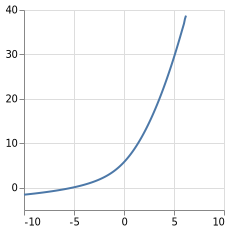

In [35]:
x = collect(-10:0.1:10)
y = T.(x)
p = @vlplot(:line, x,y)

### Example with 1D Finite Discrete Distributions

Optimal Trasnport Cost = 14.473957823245271


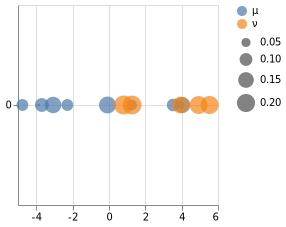

In [76]:
n   = 10
u   = rand(n)*10 .- 5
u_w = rand(n)
u_w = u_w./sum(u_w)
μ = DiscreteNonParametric(u, u_w);

m   = 5
v   = rand(m)*10
v_w = rand(m)
v_w = v_w./sum(v_w)
ν = DiscreteNonParametric(v, v_w);

c(x,y) = (x-y)^2

X = vcat(u,v)
Y = zeros(length(u)+length(v))
P = vcat(u_w,v_w);
C = vcat(["μ" for i in 1:n],["ν" for i in 1:m])

cost, T = otCostPlan1d(c,μ,ν);

println("Optimal Trasnport Cost = ",cost)
@vlplot(:circle, X,Y, size={P}, color={C})

In [77]:
T

10×5 Matrix{Float64}:
 0.0860547   0.0        0.0        0.0         0.0
 0.00409462  0.0        0.0        0.0         0.0
 0.116532    0.0        0.0        0.0         0.0
 0.0131073   0.151895   0.0        0.0         0.0
 0.0         0.0643347  0.0208456  0.0         0.0
 0.0         0.0        0.149734   0.0252188   0.0
 0.0         0.0        0.0        0.0721905   0.0
 0.0         0.0        0.0        0.0965498   0.0
 0.0         0.0        0.0        0.00190468  0.0397891
 0.0         0.0        0.0        0.0         0.157749

In [116]:
# Discrete Case
n,m = 100, 150

μ = rand(n)
ν = rand(m) .+ 0.5;
μ_n = rand(n)
ν_m = rand(m)
μ_n = μ_n/sum(μ_n)
ν_m = ν_m/sum(ν_m);

c(x,y) = (x-y)^2
C = Distances.pairwise(Distances.SqEuclidean(), μ', ν');

lp = Tulip.Optimizer()
cost = emd2(μ_n, ν_m, C, lp)
cost1 = otCost1d(c,μ,μ_n,ν,ν_m)

P = emd(μ_n, ν_m, C, lp)
γ = otPlan1d(c,μ,μ_n,ν,ν_m)

100×150 Matrix{Float64}:
 0.0         0.0  0.0  0.0  0.0         …  0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0         …  0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.000112421  0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0         …  0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0
 0.0         0.0  0.0  0.0  0.0            0.0  0.0  0.0  0.0          0.0


In [114]:
μ

100-element Vector{Float64}:
 0.17148652305317902
 0.3515720697800544
 0.5352566511133372
 0.14412923000189992
 0.7331356937634983
 0.29327396171738873
 0.4790368893100454
 0.14268787727986454
 0.9489178770774602
 0.6599446085343081
 0.9543572782248995
 0.540807104841966
 0.4104585259410949
 ⋮
 0.9150184754460184
 0.7905152196388787
 0.8692044622410209
 0.9859680704931981
 0.17112897639656666
 0.506925917682356
 0.37224560594593403
 0.4069854750231183
 0.9793913162235581
 0.07635000970563688
 0.7396190675026371
 0.8121755754496536